In [30]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting
import datetime                   # library for date manipulation

from sklearn.decomposition import PCA
from scipy.stats import norm, rankdata
from scipy.interpolate import interp1d

from os import path, makedirs

import sys
sys.path.append("../src/confer_wp3/")
from plotting import plot_fields                                    # function for visualizing spatial data in a map
from lasso_forecast import calculate_tercile_probability_forecasts

The following two variables specify the paths where the forecast and observation data are stored:

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loading, and save out.

### Testing

In [19]:
# Predictors: uwind200, uwind850, sst, chirps
# Dir: era5_dir or chirps_dir
    
def load_raw_data(dir, predictor, bounding_box, years, season=None):
    # Construct file path
    if predictor == "sst":
        pth = "sst/full.nc"
    elif predictor == "uwind200":
        pth = "uwind/200hpa/full.nc"
    elif predictor == "uwind850":
        pth = "uwind/850hpa/full.nc"
    elif predictor == "chirps":
        pth = "prec_raw.nc"
    file_path = f"{dir}{pth}"
    
    # Load data
    data = xr.open_dataset(file_path)
    
    # Subset data based on bounding box
    lon_min, lon_max, lat_min, lat_max = bounding_box
    data = data.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    # Subset data based on years
    data = data.sel(year=slice(years[0], years[-1]))
    
    # Aggregate by season if provided
    if predictor == "chirps" and season is not None:
        if season == 'OND':
            season_months = [10, 11, 12]
        elif season == 'MAM':
            season_months = [3, 4, 5]
        elif season == 'JJAS':
            season_months = [6, 7, 8, 9]
        data = data.sel(month=np.isin(data['month'], season_months))
        data = data.groupby('year').sum(dim='month')
    
    # Convert to NumPy arrays
    year = data['year'].values
    lon = data['lon'].values
    lat = data['lat'].values

    if predictor == "chirps":
        predictor_values = data['prec'].values # Shape: (year, lat, lon)
    elif predictor == "uwind200" or predictor == "uwind850":
        predictor_values = data['uwind'].values
    elif predictor == "sst":
        predictor_values = data['sst'].values
    
    return year, lon, lat, predictor_values

#### Loading tests

In [20]:
sst_data_test = xr.open_dataset(f"{era5_dir}/sst/full.nc")
sst_data_test

<xarray.Dataset>
Dimensions:  (year: 71, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1950 1951 1952 1953 1954 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [21]:
uwind_200hpa_data_test = xr.open_dataset(f"{era5_dir}/uwind/200hpa/full.nc")
uwind_200hpa_data_test

<xarray.Dataset>
Dimensions:  (year: 74, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022 2023
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [22]:
uwind_850hpa_data_test = xr.open_dataset(f"{era5_dir}/uwind/850hpa/full.nc")
uwind_850hpa_data_test

<xarray.Dataset>
Dimensions:  (year: 74, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022 2023
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

### CHIRPS DATA

Raw CHIRPS data:  
(year, month, lon, lat, prec)  
year 1981 - 2023   
month 1-12  
lat -11.5 to 21.5  
lon 22.0 to 51.0  
one prec value for each combination of the four above  

##### Loading data

In [23]:
# TESTING
test_dir = "/nr/samba/user/ahellevik/CONFER-WP3/testdata/"

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
year, lon, lat, prec_data = load_raw_data(chirps_dir, "chirps", box, [i for i in range(1981, 2021)], season=season)
prec_data.shape

(40, 67, 59)

##### Calculate anomalies

In [24]:
# Restrict to the geographical bounds
lon_mask = (lon >= lon_bnds[0]) & (lon <= lon_bnds[1])
lat_mask = (lat >= lat_bnds[0]) & (lat <= lat_bnds[1])

lon = lon[lon_mask]
lat = lat[lat_mask]
prec_data = prec_data[:, lat_mask, :][:, :, lon_mask]

# Select the reference period using a boolean mask
ref_period_mask = (year >= year_clm_start) & (year <= year_clm_end)
ref_period_indices = np.where(ref_period_mask)[0]

# Calculate climatology (mean over the reference period)
climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)

# Calculate anomalies by subtracting climatology
anomalies = prec_data - climatology[np.newaxis, :, :]

print(prec_data.shape)
print(anomalies.shape)

(40, 67, 59)
(40, 67, 59)


##### Visualize calculation of anomalies for a random month/year pair

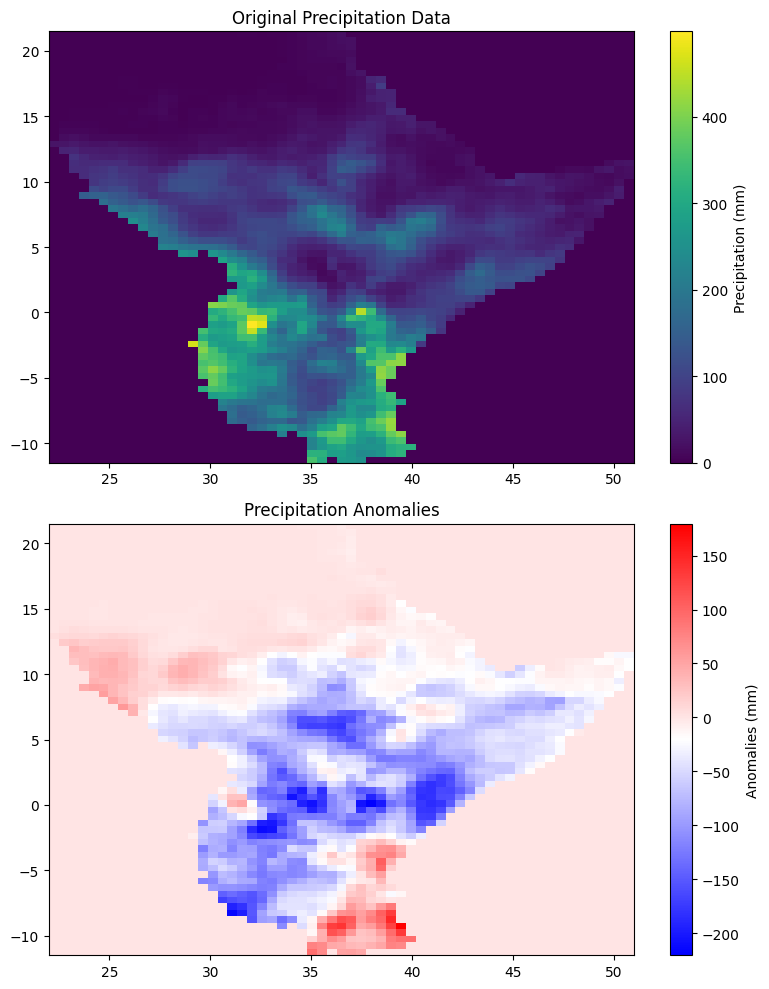

In [25]:
# Plot original precipitation data
plt.figure(figsize=(8, 10))  # Adjusting figsize for a more even aspect ratio
plt.subplot(2, 1, 1)
plt.title('Original Precipitation Data')
plt.imshow(prec_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')

# Plot anomalies
plt.subplot(2, 1, 2)
plt.title('Precipitation Anomalies')
plt.imshow(anomalies[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='bwr', aspect='auto')
plt.colorbar(label='Anomalies (mm)')
plt.tight_layout()
plt.show()

##### Transform anomalies to normal dist. using quantile mapping

In [113]:
def quantile_mapping(data, ref_indices):
    transformed_data = np.empty_like(data)
    
    # Standard deviation for the reference period at each grid point
    ref_period_std = np.nanstd(data[ref_indices, :, :], axis=0)

    # Prevent division by zero by setting zero standard deviations to a small positive value
    ref_period_std[ref_period_std == 0] = 1e-10
    
    for lat_idx in range(data.shape[1]):
        for lon_idx in range(data.shape[2]):
            ref_data = data[ref_indices, lat_idx, lon_idx]
            ref_data = ref_data[~np.isnan(ref_data) & np.isfinite(ref_data)]
            
            if ref_data.size == 0:
                continue
            
            # Calculate ranks and percentiles for the reference period
            ref_ranks = rankdata(ref_data)
            ref_percentiles = (ref_ranks - 1) / (len(ref_data) - 1)
            ref_normal = norm.ppf(ref_percentiles)
            
            # Interpolator for reference period quantiles
            interp_func = interp1d(ref_percentiles, ref_normal, kind='linear', fill_value=(ref_normal[0], ref_normal[-1]), bounds_error=False)
            
            all_years_data = data[:, lat_idx, lon_idx]
            valid_mask = ~np.isnan(all_years_data) & np.isfinite(all_years_data)
            all_years_data_valid = all_years_data[valid_mask]
            
            if all_years_data_valid.size == 0:
                continue
            
            # Interpolation of normal quantiles using reference period
            all_years_normal = interp_func(all_years_data_valid)
            
            # Replace any inf values introduced during interpolation with NaN
            all_years_normal[np.isinf(all_years_normal)] = np.nan
            
            # Standardize the normal values using the reference period mean and standard deviation
            all_years_normal_standardized = (all_years_normal * ref_period_std[lat_idx, lon_idx])
                        
            # Replace any NaN values introduced during standardization
            nan_mask = np.isnan(all_years_normal_standardized)
            if np.any(nan_mask):
                all_years_normal_standardized[nan_mask] = np.nanmean(all_years_normal_standardized[~nan_mask])
            
            # Place standardized values back in the original array shape
            reshaped_data = np.full(data.shape[0], np.nan)
            reshaped_data[valid_mask] = all_years_normal_standardized
            transformed_data[:, lat_idx, lon_idx] = reshaped_data

    return transformed_data

In [114]:
# Apply the transformation to the anomalies data
anomalies_normal = quantile_mapping(anomalies, ref_period_indices)

/tmp/ipykernel_1311350/42348589.py:45: RuntimeWarning: Mean of empty slice
  all_years_normal_standardized[nan_mask] = np.nanmean(all_years_normal_standardized[~nan_mask])


In [115]:
# Saving, if wanted

# Convert to xarray DataArray for saving as NetCDF
anomalies_xr = xr.DataArray(anomalies, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])
anomalies_normal_xr = xr.DataArray(anomalies_normal, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])

# Save the anomalies and transformed anomalies
anomalies_xr.to_netcdf(f"{test_dir}/chirps_anomalies.nc")
anomalies_normal_xr.to_netcdf(f"{test_dir}/chirps_anomalies_normal.nc")

##### Plots to ensure processing anomalies went well

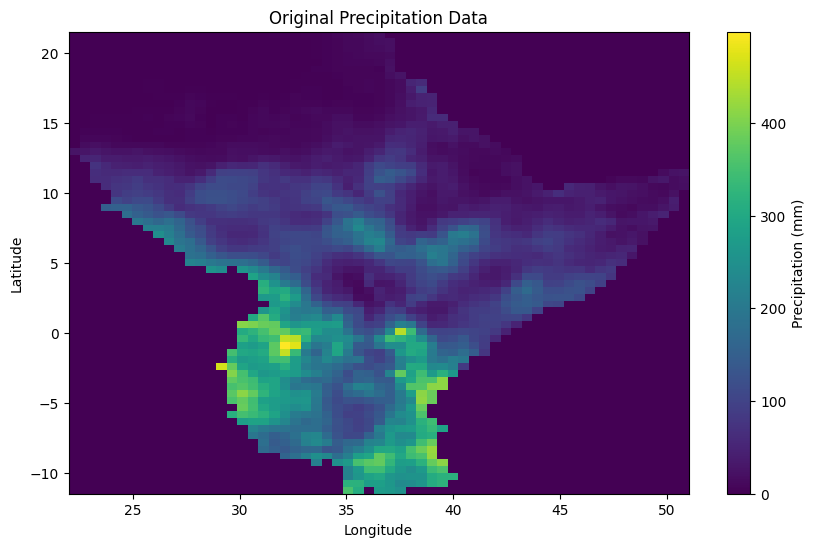

In [116]:
selected_year = 0  # First year in the dataset

plt.figure(figsize=(10, 6))
plt.title('Original Precipitation Data')
plt.imshow(prec_data[selected_year, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

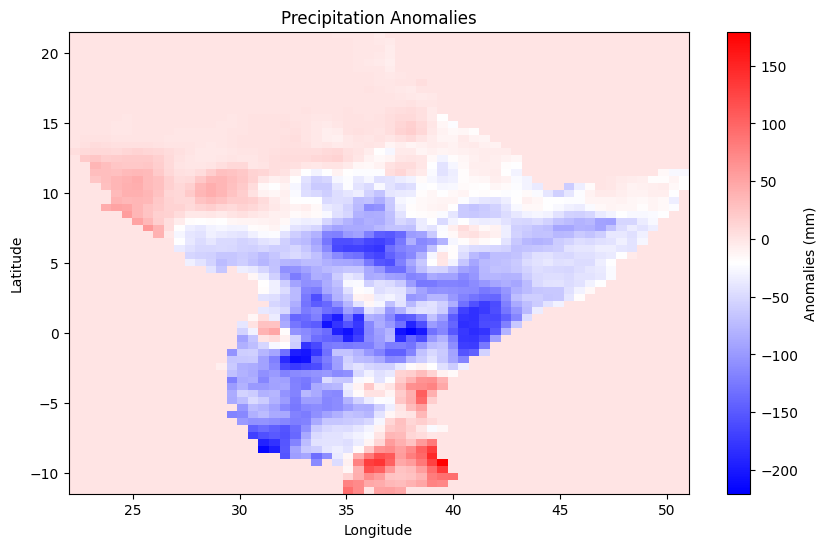

In [117]:
plt.figure(figsize=(10, 6))
plt.title('Precipitation Anomalies')
plt.imshow(anomalies[selected_year, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='bwr', aspect='auto')
plt.colorbar(label='Anomalies (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


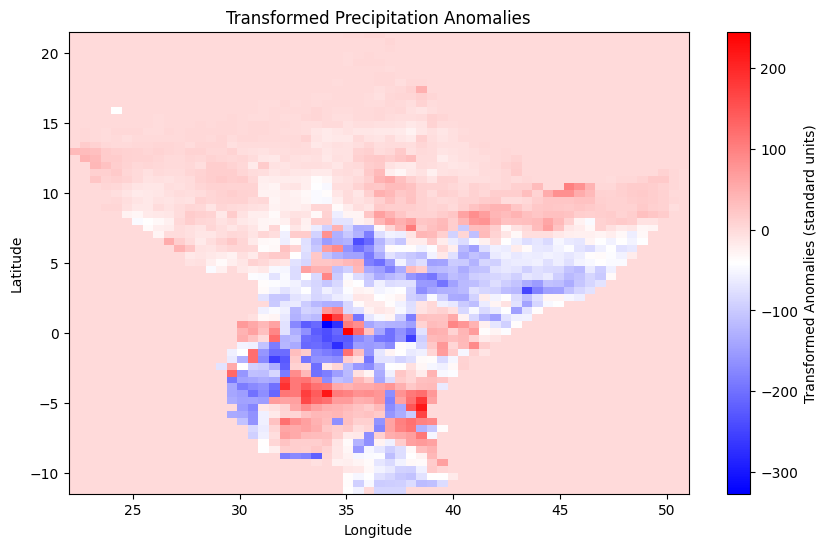

In [118]:
plt.figure(figsize=(10, 6))
plt.title('Transformed Precipitation Anomalies')
plt.imshow(anomalies_normal[selected_year, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='bwr', aspect='auto')
plt.colorbar(label='Transformed Anomalies (standard units)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


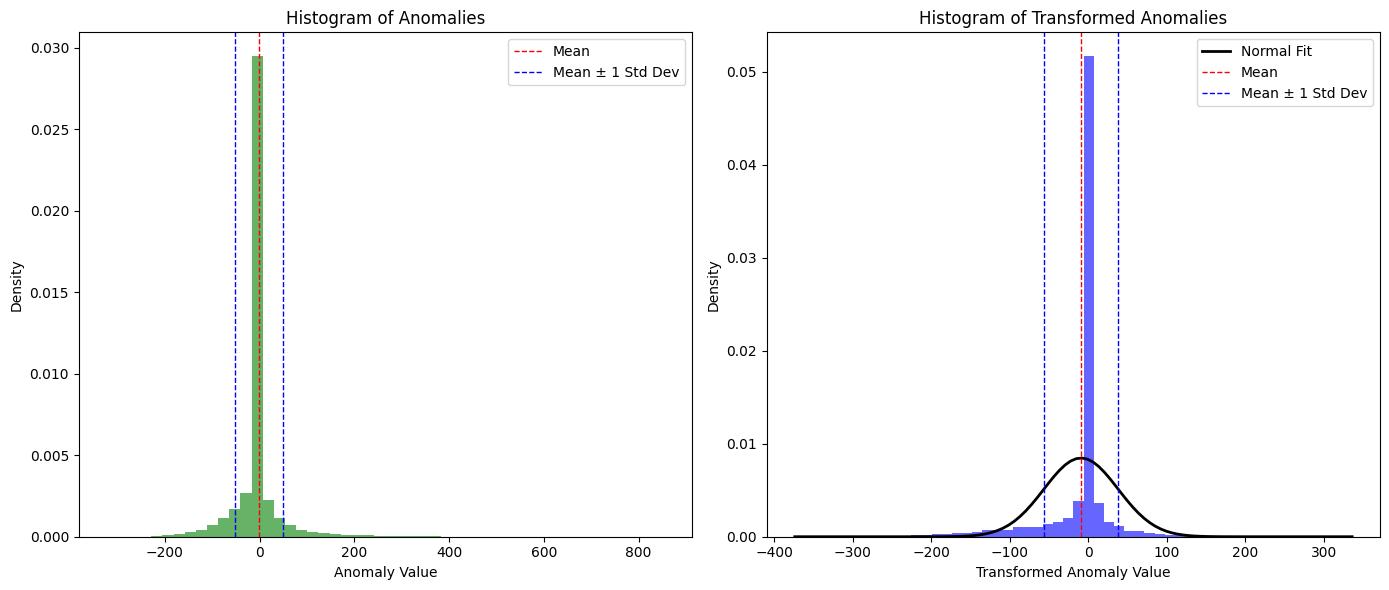

In [121]:

# Flatten the arrays and filter out non-finite values
anomalies_flat = anomalies.flatten()
anomalies_normal_flat = anomalies_normal.flatten()

# Remove non-finite values
anomalies_flat = anomalies_flat[np.isfinite(anomalies_flat)]
anomalies_normal_flat = anomalies_normal_flat[np.isfinite(anomalies_normal_flat)]

plt.figure(figsize=(14, 6))

# Original anomalies histogram
plt.subplot(1, 2, 1)
plt.hist(anomalies_flat, bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Anomalies')
plt.xlabel('Anomaly Value')
plt.ylabel('Density')
plt.axvline(np.mean(anomalies_flat), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(anomalies_flat) + np.std(anomalies_flat), color='b', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(anomalies_flat) - np.std(anomalies_flat), color='b', linestyle='dashed', linewidth=1)
plt.legend(['Mean', 'Mean ± 1 Std Dev'])

# Transformed anomalies histogram
plt.subplot(1, 2, 2)
plt.hist(anomalies_normal_flat, bins=50, density=True, alpha=0.6, color='b')

# Overlay normal distribution curve
mu, std = norm.fit(anomalies_normal_flat)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram of Transformed Anomalies')
plt.xlabel('Transformed Anomaly Value')
plt.ylabel('Density')
plt.axvline(mu, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mu + std, color='b', linestyle='dashed', linewidth=1)
plt.axvline(mu - std, color='b', linestyle='dashed', linewidth=1)
plt.legend(['Normal Fit', 'Mean', 'Mean ± 1 Std Dev'])

plt.tight_layout()
plt.show()

In [120]:
print("Anomalies - mean:", np.nanmean(anomalies), "std:", np.nanstd(anomalies))
print("Transformed Anomalies - mean:", np.nanmean(anomalies_normal), "std:", np.nanstd(anomalies_normal))

# Check for any inf values
print("Inf values in anomalies:", np.isinf(anomalies).sum())
print("Inf values in transformed anomalies:", np.isinf(anomalies_normal).sum())

# Check for any nan values
print("NaN values in anomalies:", np.isnan(anomalies).sum())
print("NaN values in transformed anomalies:", np.isnan(anomalies_normal).sum())


Anomalies - mean: -1.9452746 std: 50.716724
Transformed Anomalies - mean: -9.306479 std: 47.13921
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 0
NaN values in transformed anomalies: 160


##### Calculate EOFs

In [56]:
# Mask invalid data points
valid_mask = ~np.isnan(anomalies)

# Flatten the spatial dimensions and keep only valid data points
anomalies_flat = anomalies.reshape(anomalies.shape[0], -1).T  # Shape: (year * lat * lon, month)
valid_mask_flat = valid_mask.reshape(anomalies.shape[0], -1).T  # Same shape as anomalies_flat

# Apply the mask to get valid anomalies
anomalies_valid = anomalies_flat[valid_mask_flat.all(axis=1), :]

# Check for NaNs in anomalies_valid
num_nans = np.isnan(anomalies_valid).sum()
print(f"Number of NaNs in anomalies_valid: {num_nans}")
print(f"Shape of anomalies_valid: {anomalies_valid.shape}")

# Investigate the source of NaNs
nan_indices = np.where(np.isnan(anomalies_valid))
print(f"NaN indices in anomalies_valid: {nan_indices}")

# Ensure no NaNs are present
if num_nans > 0:
    raise ValueError("NaNs are present in the anomalies_valid array")

# Perform EOF analysis using PCA
nEOF = 3  # Number of EOFs to retain
pca = PCA(n_components=nEOF)
pcs = pca.fit_transform(anomalies_valid)
eofs = pca.components_

# Reshape EOFs back to the original shape with NaNs where appropriate
eofs_full = np.full((nEOF, anomalies.shape[2], anomalies.shape[3], anomalies.shape[0]), np.nan)

# Use valid_mask_flat to determine valid indices for each spatial location
valid_indices_flat = np.where(valid_mask_flat.any(axis=1))[0]

print(f"valid_indices_flat size: {len(valid_indices_flat)}, eofs_full flat size: {eofs_full[0].size}")

# Truncate valid_indices_flat to match the size of eofs_full flat
valid_indices_flat_truncated = valid_indices_flat[:eofs_full[0].size]

# Map EOFs back to their spatial positions
for i in range(nEOF):
    eofs_full[i].flat[valid_indices_flat_truncated] = eofs[i]

# Transpose EOFs to match the original data shape (mode, month, lat, lon)
eofs_full = eofs_full.transpose(0, 3, 1, 2)
print(eofs_full.shape)


Number of NaNs in anomalies_valid: 0
Shape of anomalies_valid: (86016, 12)
NaN indices in anomalies_valid: (array([], dtype=int64), array([], dtype=int64))
valid_indices_flat size: 88064, eofs_full flat size: 47436


IndexError: index 47462 is out of bounds for size 47436

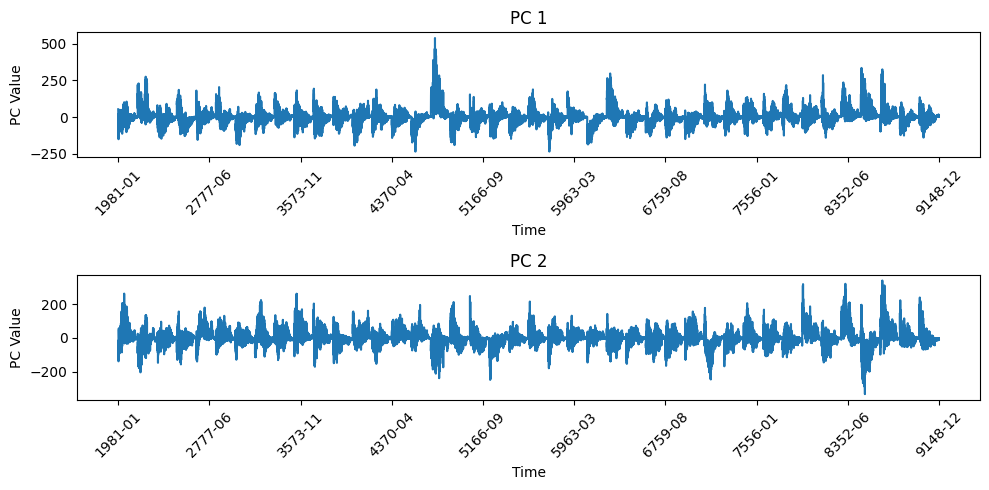

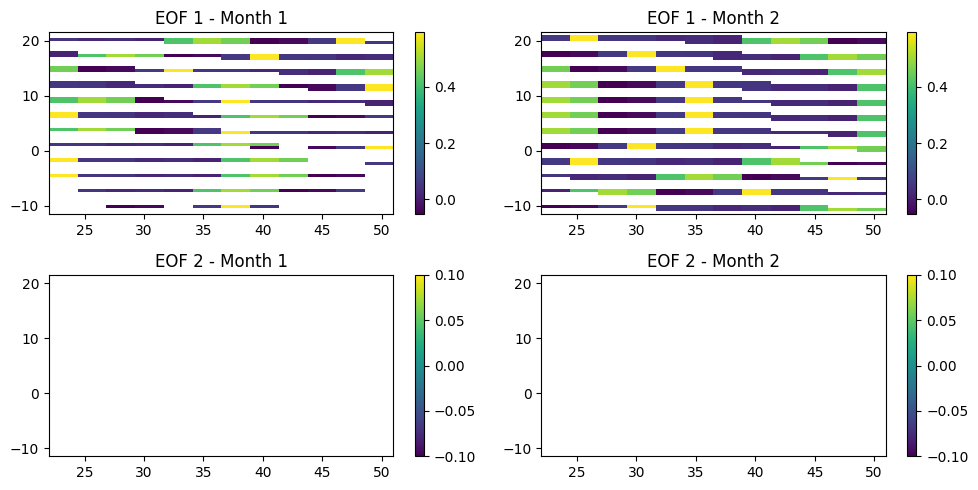

In [46]:
# Adjust the time axis for PCs
# Assuming we have monthly data starting from year_train_start to year_train_end
time_points = np.arange(len(pcs))  # This should be adjusted to reflect actual time periods if available

# Example adjustment (assuming time_points represent months from year_train_start to year_train_end)
# This will create a time axis with months in the format 'YYYY-MM'
start_year = year_train_start
start_month = 1
time_labels = [f"{start_year + (start_month + i - 1) // 12}-{(start_month + i - 1) % 12 + 1:02d}" for i in range(len(pcs))]

nEOF_to_plot = 2
n_months_to_plot = 2

# Plot the first few PCs with adjusted time axis
fig, axes = plt.subplots(nEOF_to_plot, 1, figsize=(10, 5))

for i in range(nEOF_to_plot):
    ax = axes[i] if nEOF_to_plot > 1 else axes
    ax.plot(time_points, pcs[:, i])
    ax.set_title(f'PC {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('PC Value')
    ax.set_xticks(np.linspace(0, len(time_points) - 1, 10))  # Adjust the number of ticks
    ax.set_xticklabels([time_labels[int(x)] for x in np.linspace(0, len(time_points) - 1, 10)], rotation=45)

plt.tight_layout()
plt.show()

# Plot the first few EOFs
fig, axes = plt.subplots(nEOF_to_plot, n_months_to_plot, figsize=(10, 5))

for i in range(nEOF_to_plot):
    for j in range(n_months_to_plot):
        ax = axes[i, j] if nEOF_to_plot > 1 else axes[j]
        eof_plot = eofs_full[i, j, :, :]
        im = ax.imshow(eof_plot, aspect='auto', origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])
        ax.set_title(f'EOF {i+1} - Month {j+1}')
        fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [34]:
# Save the results as NumPy arrays
makedirs(test_dir, exist_ok=True)
# Optionally, convert back to xarray and save as netCDF
anomalies_xr = xr.DataArray(anomalies, coords=[month, year, lat, lon], dims=['month', 'year', 'lat', 'lon'])
eofs_xr = xr.DataArray(eofs_full, coords=[range(nEOF), month, lat, lon], dims=['mode', 'month', 'lat', 'lon'])
pcs_xr = xr.DataArray(pcs, coords=[range(anomalies_valid.shape[0]), range(nEOF)], dims=['time_space', 'mode'])

anomalies_xr.to_netcdf(f"{test_dir}/anomalies.nc")
eofs_xr.to_netcdf(f"{test_dir}/eofs.nc")
pcs_xr.to_netcdf(f"{test_dir}/pcs.nc")

ValueError: conflicting sizes for dimension 'month': length 67 on the data but length 12 on coordinate 'month'

In [13]:
#filename_pct_target = f'{percentile_dir}percentiles_{target}_{year_train_start}_{year_train_end}.nc'

#if not path.exists(filename_pct_target):
#    calculate_target_percentiles(target, year_train_start, year_train_end, lon_bnds, lat_bnds, target_dir, filename_pct_target)

data_load = xr.open_dataset(f'{anomaly_dir}refper_{period_clm[0]}-{period_clm[1]}/precip_full_{season}.nc', engine='netcdf4')
lon = data_load.lon.values
lat = data_load.lat.values
data_load.close()

nlon = len(lon)
nlat = len(lat)

If not already available, load ERA5 data, calculate indices, and save out.

In [1]:
# do it

Run LASSO model to predict precipitation EOFs based on indices.

In [ ]:
# do it

Visualize fitted coefficients

In [ ]:
# do it

Load indices for the forecast year and use the previously fitted model to make a forecast

In [4]:
prob_fcst_below, prob_fcst_above = calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_train, period_clm, indices_dir, anomaly_dir, eof_dir, fcst_dir)

Depict as a map.

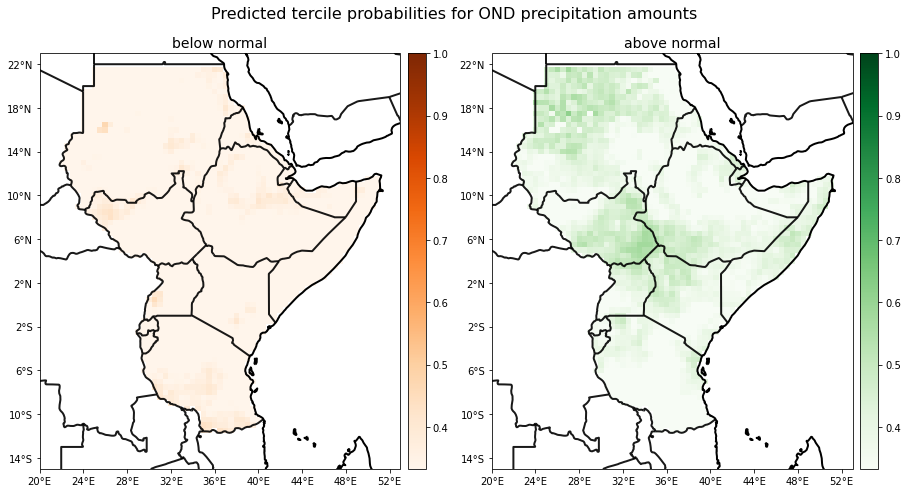

In [10]:
plot_fields (fields_list = [prob_fcst_below, prob_fcst_above],
          lon = lon,
          lat = lat,
          lon_bounds = lon_bnds,
          lat_bounds = lat_bnds,
          main_title = f'Predicted tercile probabilities for {season} precipitation amounts',
          subtitle_list = ['below normal','above normal'],
          vmin = 0.333,
          vmax = 1,
          cmap = ['Oranges','Greens'],
          unit = '')